In [61]:
import pandas as pd
import numpy as np

In [62]:
from wordcloud import WordCloud, STOPWORDS

In [63]:
import lightgbm

In [64]:
from sklearn.preprocessing import LabelEncoder

In [65]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [66]:
from nltk.stem import PorterStemmer

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [68]:
from nltk.corpus import stopwords
stopwords=stopwords.words("english")

In [69]:
import re

In [70]:
import matplotlib.pyplot as plt

In [71]:
df=pd.read_json("crawler-tid/tweets_json",lines=True)

In [72]:
df=df[['id','text']]

In [73]:
df.shape

(3930, 2)

In [74]:
df_att=pd.read_csv("chdata/att")
df_verizon=pd.read_csv("chdata/verizon")
df_t=pd.read_csv("chdata/t-mobile")

In [75]:
df_label=pd.concat([df_att,df_verizon,df_t],axis=0)

In [76]:
df_label=df_label[['brand','tid','choose_one','choose_one:confidence']]
df_label.columns=['brand','id','choose_one',"choose_one:confidence"]

In [77]:
mainDF=pd.merge(df,df_label,on="id")

In [78]:
mainDF=mainDF[['id','text','brand','choose_one']]

In [79]:
mainDF[mainDF['choose_one']=='Churny'].shape

(827, 4)

In [80]:
mainDF[mainDF['choose_one']=='Non-churny'].shape

(3103, 4)

In [81]:
mainDF.to_csv("MergedDF.csv",index=None)

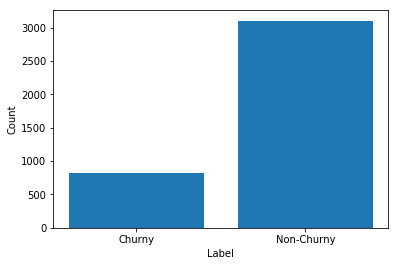

In [82]:
plt.bar([0,1],[827,3103])
plt.xticks([0,1],['Churny','Non-Churny'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.savefig("plots/dataDistribution.png")
plt.show()
plt.close()

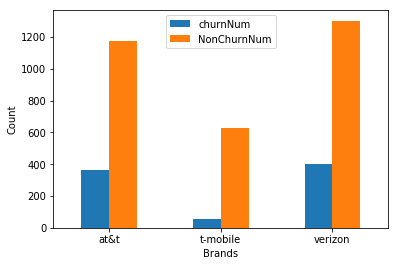

In [83]:
brands=np.unique(mainDF['brand'])
brandInfo={}
brandInfo['brand']=[]
brandInfo['churnNum']=[]
brandInfo['NonChurnNum']=[]
for brand in brands:
    brandInfo['brand'].append(brand)
    brandInfo['churnNum'].append(mainDF[(mainDF['brand']==brand) & (mainDF['choose_one']=="Churny")].shape[0])
    brandInfo['NonChurnNum'].append(mainDF[(mainDF['brand']==brand) & (mainDF['choose_one']=="Non-churny")].shape[0])
x=pd.DataFrame(brandInfo)
x=x.set_index("brand")
x.plot.bar(rot=0)
plt.xlabel("Brands")
plt.ylabel("Count")
plt.savefig("plots/brandDistribution.png")
plt.show()
plt.close()

In [84]:
mainDF.isna().sum()

id            0
text          0
brand         0
choose_one    0
dtype: int64

In [85]:
mainDF[mainDF.choose_one=='Churny'].text.iloc()[500]

'@KushSectionOnly lmfaoooo no forreal i need him to unlock my 5 cause im leaving AT&amp;T'

In [86]:
mainDF[mainDF.choose_one=='Churny'].text.iloc()[500]

'@KushSectionOnly lmfaoooo no forreal i need him to unlock my 5 cause im leaving AT&amp;T'

## Preprocessing

In [87]:
replaceWord="<bb>"
brands={}
brands['t-mobile']=['t-mobile','tmobile','tmobi']
brands['verizon']=['verizon','veryzon']
brands['at&t']=['att','at&t',]
for i in range(len(mainDF)):
    brand=mainDF.iloc()[i].brand
    text=mainDF.iloc()[i].text
    text=text.replace("&amp;","&")
    text=text.replace("amp;",'&')
    for key,value in brands.items():
        if(key==brand):
            replaceWord=" <bb> "
        else:
            replaceWord=" <aa> "
            
        for name in value:
            text=text.replace(name,replaceWord)
    mainDF.iloc[i,mainDF.columns.get_loc('text')]=text
    if(i%500==0):
        print("Done for i="+str(i))


Done for i=0
Done for i=500
Done for i=1000
Done for i=1500
Done for i=2000
Done for i=2500
Done for i=3000
Done for i=3500


In [88]:
mainDF[mainDF.choose_one=="Churny"].iloc[600].text

'I have 2 months to decide if i stay w/  <bb>  or switch to  <aa>  and also if i wanna get the iphone 5 or S III'

In [89]:
porter=PorterStemmer()
def preprocessing(a_tweet):
    cleanTweet=[]
    a_tweet=a_tweet.replace("&amp;",'&')
    a_tweet=a_tweet.replace(".","")
    a_tweet=a_tweet.lower()
    a_tweet=a_tweet.split(" ")
    for word in a_tweet:
        word=word.strip()

        valid=re.search(pattern=r"[^A-Za-z-&<>]",string=word)==None
        if(word!="" and valid==True and word not in stopwords):
            word=porter.stem(word)
            cleanTweet.append(word)
    if(len(cleanTweet)==0):
        return None
    else:
        return " ".join(cleanTweet)
    return " ".join(cleanTweet)

In [90]:
mainDF['text']=mainDF['text'].apply(preprocessing)

In [91]:
mainDF[mainDF.choose_one=='Churny'].text.iloc()[600]

'month decid stay <bb> switch <aa> also wanna get iphon iii'

In [92]:
mainDF=mainDF.dropna()

In [93]:
mainDF['brand'].unique()

array(['verizon', 'at&t', 't-mobile'], dtype=object)

In [ ]:
wordcloud=WordCloud(height=800,width=1000,stopwords=STOPWORDS).generate(" ".join(df['text']))
plt.imshow(wordcloud)
plt.savefig("plots/BeforeGeneralWordCloud.png")
plt.show()

In [ ]:
wordcloud=WordCloud(height=800,width=1000,stopwords=STOPWORDS).generate(" ".join(mainDF[mainDF.choose_one=="Churny"].text.values))
plt.imshow(wordcloud)
plt.savefig("plots/BeforeChurnWordCloud.png")
plt.show()

In [ ]:
wordcloud=WordCloud(height=600,width=800,stopwords=STOPWORDS).generate(" ".join(mainDF[mainDF.choose_one=="Non-churny"].text.values))
plt.imshow(wordcloud)
plt.savefig("NonChurnWordCloud.png")
plt.show()

In [ ]:
mainDF.columns

In [ ]:
testDF=mainDF.copy()

In [ ]:
mainDF[mainDF.choose_one=="Churny"].iloc[600].text

In [ ]:
testDF[testDF.choose_one=="Churny"].iloc[600].text

In [ ]:
wordcloud=WordCloud(height=600,width=800,stopwords=['<aa>,<bb>','aa','bb']).generate(" ".join(mainDF['text']))
plt.imshow(wordcloud)
plt.savefig("GeneralWordCloud.png")
plt.show()

In [ ]:
wordcloud=WordCloud(height=600,width=800,stopwords=['<aa>,<bb>','aa','bb']).generate(" ".join(mainDF[mainDF.choose_one=="Churny"].text.values))
plt.imshow(wordcloud)
plt.savefig("ChurnWordCloud.png")
plt.show()

In [ ]:
wordcloud=WordCloud(height=600,width=800,stopwords=['<aa>,<bb>','aa','bb']).generate(" ".join(mainDF[mainDF.choose_one=="Non-churny"].text.values))
plt.imshow(wordcloud)
plt.savefig("NonChurnWordCloud.png")
plt.show()

# Feature Selection

In [99]:
vocabLen=[]

In [103]:
countVect=CountVectorizer(ngram_range=(1,3))
X=countVect.fit_transform(mainDF['text'])

In [104]:
vocabLen.append(len(countVect.vocabulary_))

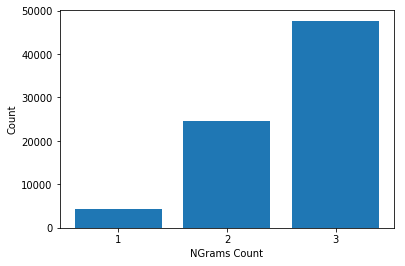

In [107]:
plt.bar([1,2,3],vocabLen)
plt.xticks([1,2,3],[1,2,3])
plt.xlabel("NGrams Count")
plt.ylabel("Count")
plt.savefig("plots/countVecVocCount.png")
plt.show()

In [ ]:
y=LabelEncoder().fit_transform(mainDF.choose_one)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y.ravel(),shuffle=True)

# Creating Classification

In [ ]:
def createSummary(y_test,y_pred):
    class0List=np.where(y_test==0)
    class1List=np.where(y_test==1)
    sumDict={}
    sumDict['accuracy']=np.mean(y_test==y_pred)
    sumDict['class0Accuracy']=np.mean(y_test[class0List]==y_pred[class0List])
    sumDict['class1Accuracy']=np.mean(y_test[class1List]==y_pred[class1List])
    sumDict['precision']=precision_score(y_test,y_pred)
    sumDict['recall']=recall_score(y_test,y_pred)
    sumDict['f1-score']=f1_score(y_test,y_pred)
    sumDict['auc']=roc_auc_score(y_test,y_pred)
    sumDict['confuseMatrix']=confusion_matrix(y_test,y_pred)
    print(classification_report(y_test,y_pred,target_names=['class 0','class 1']))
#     print(sumDict)
    return sumDict

In [ ]:
decTree=DecisionTreeClassifier()
decTree.fit(X_train,y_train)
y_pred=decTree.predict(X_test)
createSummary(y_test,y_pred)

In [ ]:
svcModel=SVC()
svcModel.fit(X_train,y_train)
y_pred=svcModel.predict(X_test)
createSummary(y_test,y_pred)

In [ ]:
LogReg=LogisticRegression()
LogReg.fit(X_train,y_train)
y_pred=LogReg.predict(X_test)
createSummary(y_test,y_pred)

In [ ]:
ranFor=RandomForestClassifier(class_weight={0:5,1:1})
ranFor.fit(X_train,y_train)
y_pred=ranFor.predict(X_test)
createSummary(y_pred,y_test)

In [ ]:
linSvc=LinearSVC()
linSvc.fit(X_train,y_train)
y_pred=linSvc.predict(X_test)
createSummary(y_test,y_pred)

In [ ]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}
X_test=X_test.astype("float")
X_train=X_train.astype("float")

train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=10)
#

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
accList=[]
class0List=[]
class1List=[]
for i in np.arange(0.05,0.95,0.05):
    y_pred_1=np.where(y_pred>i,1,0)
    sumDict=createSummary(y_test,y_pred_1)
    accList.append(sumDict['accuracy']*100)
    class0List.append(sumDict['class0Accuracy']*100)
    print("SADSD="+str(i))
    print("ACcuracy=",sumDict['class0Accuracy'])
    class1List.append(sumDict['class1Accuracy']*100)

In [ ]:
np.arange(0,0.95,0.05)

In [ ]:
plt.plot(accList)
plt.plot(class0List)
plt.plot(class1List)
plt.xlabel("CutOff")
plt.ylabel("Accuracy")
plt.legend(["Accuracy","Churn Accuracy","Non Churn Accuracy"])
plt.xticks(np.arange(0,19,1),np.arange(0.05,0.95,0.05),rotation="vertical")
plt.savefig("plots/LightGBMCutoff_ngrams1.png")

In [ ]:
y_pred_1=np.where(y_pred>0.60,1,0)
createSummary(y_test,y_pred_1)

In [ ]:
mainDF.to_csv("dataV2.csv",index=None)